In [37]:
# libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import utils

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load the data
behavioral = pd.read_csv("data/Behavioral/AllData.csv")
# eeg_average = pd.read_csv("data/EEG/resting_eeg_average.csv")
# eeg_channels = pd.read_csv("data/EEG/resting_eeg_channels.csv")
# eeg_clusters = pd.read_csv("data/EEG/resting_eeg_clusters.csv")

# general info
shape = behavioral.shape  #2096, 7042
print(shape)

(2096, 7042)


In [4]:
list(filter(lambda x: "SWAN" in x, behavioral.columns))

['SWAN_01',
 'SWAN_02',
 'SWAN_03',
 'SWAN_04',
 'SWAN_05',
 'SWAN_06',
 'SWAN_07',
 'SWAN_08',
 'SWAN_09',
 'SWAN_10',
 'SWAN_11',
 'SWAN_12',
 'SWAN_13',
 'SWAN_14',
 'SWAN_15',
 'SWAN_16',
 'SWAN_17',
 'SWAN_18',
 'SWAN_IN_Avg',
 'SWAN_HY_Avg',
 'SWAN_Avg']

In [173]:
target = 'SWAN_HY_Avg'
#disease = None
disease = 'Attention-Deficit/Hyperactivity Disorder'
category = 'DX_01_Cat' #Irrelevant since we are dropping the columns after

In [174]:
# Create the dataset dropping the diagnosis columns since we are not interested in them
data = utils.create_dataset(select_disease = disease, select_category = category, SCORE = target)
try:
    data.drop(columns=['DX_01_Cat'], inplace=True)
except:
    pass
try:
    data.drop(columns=['DX_01_Sub'], inplace=True)
except:
    pass
try:
    data.drop(columns=['DX_01'], inplace=True)
except:
    pass


# Drop the rows with some NaNs

print(data.shape)
data.dropna(axis=0, inplace=True)
print(data.shape)
column_names = data.columns[2:]

(463, 371)
(450, 371)


In [175]:
data[target].unique()

array([ 1.888888,  0.666666,  1.444444,  1.222222,  0.777777,  0.555555,
        1.666666,  2.      ,  2.222222, -0.444444,  0.888888,  0.444444,
        0.333333,  2.333333,  0.111111,  0.      ,  2.777777,  1.      ,
       -0.888888,  1.333333, -0.222222,  2.555555, -0.555555,  1.555555,
       -0.111111, -1.222222, -0.666666,  1.777777,  1.111111,  0.222222,
       -2.      , -0.333333,  2.111111, -1.333333,  2.666666,  3.      ,
       -1.      , -2.333333, -1.555555, -1.777777, -2.222222, -2.666666,
       -1.111111, -2.444444, -1.444444, -3.      ])

In [176]:
# Define the labels and the features for regression
y = data[target]
X = data.drop([target, 'ID'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [177]:
# Helper function for cross-validation
def cv(model, data, labels, n_splits = 5):
    '''
    model: must be a sklearn object with .fit and .predict methods
    data: the X matrix containing the features, can be a pd.DataFrame or a np object (array or matrix)
    labels: y, can be a pd.DataFrame or a np array
    n_splits: number of desired folds
    => returns array of mean suqared error calculated on each fold
    '''
    kf = KFold(n_splits=n_splits)
    data = np.array(data)
    labels = np.array(labels)
    mses = []
    i = 1
    for train, test in kf.split(data):
        print("Split: {}".format(i), end="\r")
        X_train, X_test, y_train, y_test = data[train], data[test], labels[train], labels[test]
        model.fit(X=X_train, y=y_train)
        pred = model.predict(X_test)
        mse = sum((pred - y_test)**2)/len(test)
        mses.append(mse)
        i = i+1
    return mses

# Naive regression with the whole dataset

In [178]:
# Baseline: predict always the average
pred = np.mean(y)
mse = sum((pred - y)**2)/len(y)
print('Prediction: {}'.format(pred))
print('MSE: {}'.format(mse))

Prediction: 0.7597527822222222
MSE: 0.9256829746520547


In [179]:
# Linear regression (qua c'è qualche errore, mse troppo alto)
lr = LinearRegression()
lr_cv_res = cv(lr, data=X_scaled, labels=y, n_splits=10)
print(lr_cv_res)
print('\nAverage MSE: {}'.format(np.mean(lr_cv_res)))

[13.726560390428839, 11.678536111101089, 11.407411136243203, 12.853756749553499, 11.716286563128183, 15.611747385701554, 10.012030029087036, 11.264819270521318, 9.632618068242701, 11.12510562138996]

Average MSE: 11.902887132539739


In [180]:
# SVM
svm = SVR(kernel='rbf', C=1, epsilon=0.1)
svm_cv_res = cv(svm, data=X_scaled, labels=y, n_splits=10)
print(svm_cv_res)
print('\nAverage MSE: {}'.format(np.mean(svm_cv_res)))

[0.8483457900096906, 0.7687666163904371, 0.668689510659259, 0.9255312289404063, 0.7811757224152662, 0.9049823396092317, 0.5725072199709732, 1.2024298917934781, 0.6560587212247352, 1.5134209496891367]

Average MSE: 0.8841907990702614


In [181]:
# Random Forest
rf = RandomForestRegressor(n_estimators=200, criterion='mse', n_jobs=4)
rf_cv_res = cv(rf, data=X, labels=y, n_splits=10)
print(rf_cv_res)
print('\nAverage MSE: {}'.format(np.mean(rf_cv_res)))

[0.9335581510502703, 0.7300891439670038, 0.6787408144159226, 0.8897119836469162, 0.7701335854737061, 1.0391687293024119, 0.5541615108180572, 1.238519859482776, 0.6811699135918613, 1.5342310681148017]

Average MSE: 0.9049484759863727


# Feature Selection

In [17]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection

Most relevant feature: lh_G_oc.temp_med.Lingual_thickness


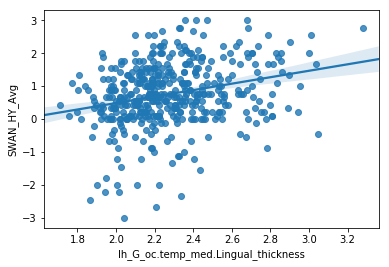

In [182]:
# Tree-based feature selection
tree = ExtraTreesRegressor(n_estimators=100, n_jobs=4)
tree = tree.fit(X=X, y=y)
weights = tree.feature_importances_

# Display correlation between most relevant feature and signal
most_relevant_feature = column_names[weights == max(weights)][0]
dataset = data[[target, most_relevant_feature]]
print('Most relevant feature: {}'.format(most_relevant_feature))
sns.regplot(x = most_relevant_feature, y = target ,data = dataset)

In [183]:
# Take the k most relevant features
k = 20
kth_weight = np.sort(weights)[::-1][k]
k_most_relevant = column_names[weights>= kth_weight]
print(k_most_relevant)

Index(['lh_G_oc.temp_med.Lingual_thickness', 'lh_G_subcallosal_thickness',
       'lh_G_temp_sup.Plan_polar_thickness',
       'lh_Lat_Fis.ant.Horizont_thickness',
       'lh_Lat_Fis.ant.Vertical_thickness', 'lh_S_calcarine_thickness',
       'lh_S_collat_transv_ant_thickness', 'rh_G.S_transv_frontopol_thickness',
       'rh_G_oc.temp_med.Lingual_thickness', 'rh_G_rectus_thickness',
       'rh_S_calcarine_thickness', 'rh_S_cingul.Marginalis_thickness',
       'rh_S_circular_insula_ant_thickness', 'lh_G_cingul.Post.dorsal_volume',
       'lh_G_precuneus_volume', 'lh_S_orbital_med.olfact_volume',
       'rh_G_cingul.Post.dorsal_volume', 'rh_G_front_inf.Triangul_volume',
       'rh_S_collat_transv_post_volume', 'rh_S_interm_prim.Jensen_volume',
       'rh_precuneus_volume'],
      dtype='object')


# Regression with selected features

Nota: in teoria questo sarebbe cheating, visto che in cross validation la feature selection andrebbe fatta solo sul training set mentre qua la stiamo facendo su tutti i dati, però lo stiamo facendo giusto per orientarci con le features e per capire se le cose migliorano in questo verso.

In [185]:
X_selected = data[list(k_most_relevant)]
X_selected_scaled = scaler.fit_transform(X_selected)
X_selected.shape

(450, 21)

In [186]:
# Linear regression
lr = LinearRegression()
lr_cv_res = cv(lr, data=X_selected, labels=y, n_splits=10)
print(lr_cv_res)
print('\nAverage MSE: {}'.format(np.mean(lr_cv_res)))

[0.7537402124625618, 0.9309739098252343, 0.7541839873496503, 0.919300400792957, 0.7360145821590538, 0.9778816987576648, 0.5470779475604204, 1.1379808086103758, 0.6876074813133918, 1.4456730667251343]

Average MSE: 0.8890434095556443


In [187]:
# SVM
svm = SVR(kernel='rbf', C=1, epsilon=0.1)
svm_cv_res = cv(svm, data=X_selected_scaled, labels=y, n_splits=10)
print(svm_cv_res)
print('\nAverage MSE: {}'.format(np.mean(svm_cv_res)))

[0.856163214322674, 0.9162690162773414, 0.5742647004464811, 0.9209680034377334, 0.848863196088377, 0.9014026855508258, 0.6259935924465103, 1.3182642369470712, 0.7017501239064305, 1.4892403835207202]

Average MSE: 0.9153179152944164


In [188]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, criterion='mse', n_jobs=4)
rf_cv_res = cv(rf, data=X_selected, labels=y, n_splits=10)
print(rf_cv_res)
print('\nAverage MSE: {}'.format(np.mean(rf_cv_res)))

[0.9292397111843924, 0.6884188816736464, 0.6871483045873654, 0.9065949006210384, 0.8616359139955498, 0.9445020277597069, 0.5433135865999406, 1.1733358733043997, 0.6642924147172983, 1.381625950961804]

Average MSE: 0.8780107565405142
